#### 🔰 **模組**

In [1]:
# third party library
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#### 🔰 **參考資料**

> Disclaimer：此篇 Notebook 並非由我產出，而是此篇 Notebook [Digit_Recognizer_ViT](https://www.kaggle.com/code/arjitdsce/digit-recognizer-vit) 之觀察筆記

+ [**使用 TensorFlow 學習 Softmax 回歸 (Softmax Regression)**](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E4%BD%BF%E7%94%A8-tensorflow-%E5%AD%B8%E7%BF%92-softmax-%E5%9B%9E%E6%AD%B8-softmax-regression-41a12b619f04)

+ [**Digit_Recognizer_ViT**](https://www.kaggle.com/code/arjitdsce/digit-recognizer-vit)

#### 🔰 **測試**

In [2]:
# 看看能不能使用 CUDA 運運算
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Mon Jan 15 23:33:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.34                 Driver Version: 537.34       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   38C    P0              29W / 215W |   1402MiB / 12282MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# 自定義資料集的載入、處理與讀取操作
class MNISTDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, transform: transforms.Compose = None, is_test: bool = False):
        super(MNISTDataset, self).__init__()
        dataset = []
        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            if is_test:
                label = -1 # 如果是測試集，把 label 設為 -1
                image = data.reshape(28, 28).astype(np.uint8)
            else:
                label = data[0]
                image = data[1:].reshape(28, 28).astype(np.uint8)
            
            if transform is not None:
                image = transform(image)
                    
            dataset.append((image, label))
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return self.dataset[i]

In [5]:
data_train = pd.read_csv("data/train.csv")
train_data = data_train.drop("label", axis=1).values

# 計算訓練集的平均值和標準差並歸一化 (0~1)
train_mean = train_data.mean() / 255
train_std = train_data.std() / 255

# 驗證集的樣本數量
eval_count = 1000

# 訓練集圖片的預處理
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
])

# 驗證集圖片的預處理
eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
])

# 測試集圖片的預處理
test_transform = eval_transform

# 訓練集
train_dataset = MNISTDataset(data_train, train_transform)

# 後 1000 筆資料當作驗證集
eval_dataset = MNISTDataset(data_train.iloc[-eval_count:], eval_transform)

  0%|          | 0/42000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
data_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_test = pd.read_csv("data/test.csv")

# 測試集
test_dataset = MNISTDataset(data_test, test_transform, is_test=True)

  0%|          | 0/28000 [00:00<?, ?it/s]

In [8]:
data_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 看看 label 有哪些 (正常而言應只有 0~9)
data_train["label"].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

In [10]:
row = data_train.iloc[1].to_numpy()
label = row[0]
digit_img = row[1:].reshape(28, 28)
print("label:", label)

label: 0


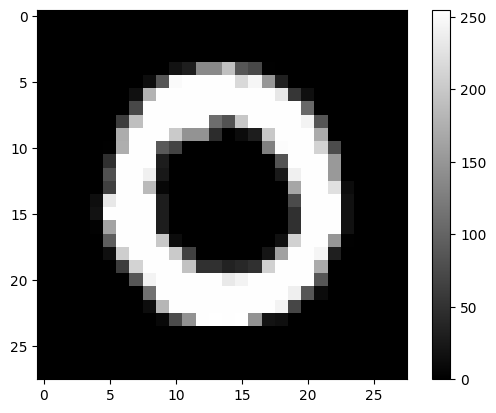

In [11]:
# 畫出熱圖 (數字，使用 data_train 用為圖像顯示，所以值落在 0~255)
plt.imshow(digit_img, interpolation="nearest", cmap="gray")
plt.colorbar()
plt.show()

In [12]:
# 這裡我還未仔細研究
# 但還是可以看的出來，這裡應該是直接手刻出一個 Transformer 模型，底下也有關於自注意力機制的實作

from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, "b n (qkv h d) -> qkv b h n d", qkv=3, h=h)

        dots = torch.einsum("bhid,bhjd->bhij", q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], "mask has incorrect dimensions"
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float("-inf"))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum("bhij,bhjd->bhid", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x
    
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, "image dimensions must be divisible by the patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [13]:
torch.manual_seed(42)

BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

In [14]:
def train_epoch(model: ViT, optimizer: torch.optim.Optimizer, data_loader: DataLoader, loss_history: list[float]) -> None:
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("[" +  "{:5}".format(i * len(data)) + "/" + "{:5}".format(total_samples) +
                  " (" + "{:3.0f}".format(100 * i / len(data_loader)) + "%)]  Loss: " +
                  "{:6.4f}".format(loss.item()))
            loss_history.append(loss.item())

In [15]:
def evaluate(model: ViT, data_loader: DataLoader, loss_history: list[float]) -> None:
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction="sum")
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print("\nAverage test loss: " + "{:.4f}".format(avg_loss) +
          "  Accuracy:" + "{:5}".format(correct_samples) + "/" +
          "{:5}".format(total_samples) + " (" +
          "{:4.2f}".format(100.0 * correct_samples / total_samples) + "%)\n")

In [16]:
import time

# 模型
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.to(device)

# 優化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train_loss_history, test_loss_history = [], []

In [17]:
# 開始訓練
N_EPOCHS = 50

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print("Epoch:", epoch, "LR:", scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, eval_loader, test_loss_history)
    scheduler.step()

print("Execution time:", "{:5.2f}".format(time.time() - start_time), "seconds")

Epoch: 1 LR: [0.1]
[    0/42000 (  0%)]  Loss: 2.3212
[10000/42000 ( 24%)]  Loss: 2.1222
[20000/42000 ( 48%)]  Loss: 1.7895
[30000/42000 ( 71%)]  Loss: 1.5804
[40000/42000 ( 95%)]  Loss: 0.9772

Average test loss: 0.6101  Accuracy:  788/ 1000 (78.80%)

Epoch: 2 LR: [0.095]
[    0/42000 (  0%)]  Loss: 1.0717
[10000/42000 ( 24%)]  Loss: 1.0175
[20000/42000 ( 48%)]  Loss: 1.0520
[30000/42000 ( 71%)]  Loss: 0.8782
[40000/42000 ( 95%)]  Loss: 0.2823

Average test loss: 0.2931  Accuracy:  913/ 1000 (91.30%)

Epoch: 3 LR: [0.09025]
[    0/42000 (  0%)]  Loss: 0.6063
[10000/42000 ( 24%)]  Loss: 0.3937
[20000/42000 ( 48%)]  Loss: 0.2914
[30000/42000 ( 71%)]  Loss: 0.3624
[40000/42000 ( 95%)]  Loss: 0.2658

Average test loss: 0.1998  Accuracy:  932/ 1000 (93.20%)

Epoch: 4 LR: [0.0857375]
[    0/42000 (  0%)]  Loss: 0.2650
[10000/42000 ( 24%)]  Loss: 0.1953
[20000/42000 ( 48%)]  Loss: 0.3877
[30000/42000 ( 71%)]  Loss: 0.4347
[40000/42000 ( 95%)]  Loss: 0.3670

Average test loss: 0.1328  Accurac

In [18]:
submission_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

submission = [["ImageId", "Label"]]

with torch.no_grad():
    model.eval()
    image_id = 1
    
    for images, _ in submission_loader:
        images = images.to(device)
        output = F.log_softmax(model(images), dim=1)
        _, pred = torch.max(output, dim=1)
        
        for prediction in pred:
            submission.append([image_id, prediction.item()])
            image_id += 1

In [46]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)
submission_df = submission_df.set_index("ImageId")
submission_df

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
...,...
27996,9
27997,7
27998,3


In [47]:
submission_df.to_csv("result/submission.csv")

#### 🔰 **我的紀錄**

In [20]:
def show_img(index: int) -> None:
    row = data_train.iloc[index].to_numpy()
    digit_img = row[1:].reshape(28, 28)
    plt.imshow(digit_img, interpolation="nearest", cmap="gray")
    plt.show()

In [21]:
def test(index: int) -> int:
    df = pd.DataFrame(data_train.iloc[index:index+1])
    dataset = MNISTDataset(df, test_transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

    with torch.no_grad():
        model.eval()
        
        for images, _ in loader:
            images = images.to(device)
            output = F.log_softmax(model(images), dim=1)
            _, pred = torch.max(output, dim=1)
            print(pred.item())

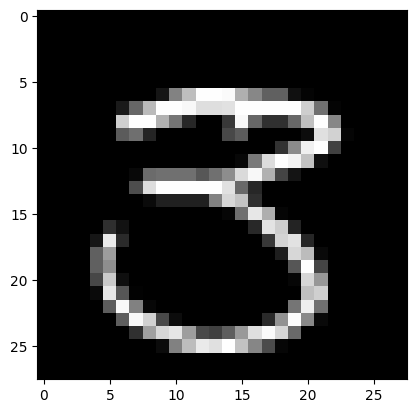

In [22]:
show_img(index=7)

In [23]:
test(index=7)

  0%|          | 0/1 [00:00<?, ?it/s]

3
